In [1]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

DEVICE = 'cuda'

# 1. Import Dataset

In [2]:
from poc_data import PocDataset

NUM_CASES = 2**5
BATCH_SIZE = 2**4

poc_raw_dataset = PocDataset(num_cases=NUM_CASES)
data_loader = torch.utils.data.DataLoader(poc_raw_dataset, batch_size=BATCH_SIZE)
batch, event, time_to_event, _latent_variable = next(iter(data_loader))

print(batch.shape)
print(event.shape)
print(time_to_event.shape)
print(_latent_variable.shape)

torch.Size([16, 10, 3])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])


### Data Exploration

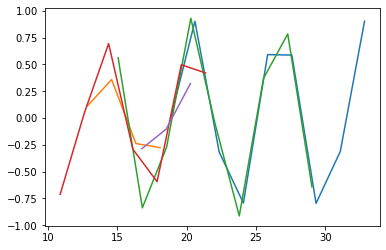

In [3]:
#Take a look at the longitudional data

plt.plot(np.array(batch[0][:int(time_to_event[0]),1]), batch[0][:int(time_to_event[0]),2])
plt.plot(np.array(batch[1][:int(time_to_event[1]),1]), batch[1][:int(time_to_event[1]),2])
plt.plot(np.array(batch[2][:int(time_to_event[2]),1]), batch[2][:int(time_to_event[2]),2])
plt.plot(np.array(batch[3][:int(time_to_event[3]),1]), batch[3][:int(time_to_event[3]),2])
plt.plot(np.array(batch[4][:int(time_to_event[4]),1]), batch[4][:int(time_to_event[4]),2])

### Test Sample

tensor([[ 0.0000e+00,  1.7427e+01, -8.9233e-01],
        [ 0.0000e+00,  1.9172e+01,  2.8622e-01],
        [ 0.0000e+00,  2.0918e+01,  7.9292e-01],
        [ 0.0000e+00,  2.2663e+01, -5.6160e-01],
        [ 0.0000e+00,  2.4408e+01, -5.9788e-01],
        [ 0.0000e+00,  2.6154e+01,  7.6925e-01],
        [ 0.0000e+00,  2.7899e+01,  3.3072e-01],
        [ 0.0000e+00,  2.9644e+01, -8.8410e-01],
        [ 0.0000e+00,  3.1390e+01, -2.3679e-02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00]], device='cuda:0')
event=1, time_to_event=9, latent_variable=0.902229


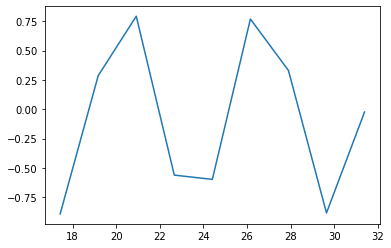

In [4]:
from poc_data import PocDataset

test_poc_raw_dataset = PocDataset(num_cases=1)
test_data_loader = torch.utils.data.DataLoader(test_poc_raw_dataset,batch_size=1)
test_batch, test_event, test_time_to_event, test_latent_variable = next(iter(test_data_loader))
test_batch = test_batch.to(DEVICE)
test_event = test_event.to(DEVICE)
test_time_to_event = test_time_to_event.to(DEVICE)

plt.plot(np.array(test_batch.cpu()[0][:int(test_time_to_event[0]),1]), test_batch.cpu()[0][:int(test_time_to_event[0]),2])
print(test_batch[0,:20])
print("event=%d, time_to_event=%d, latent_variable=%f" % (test_event.item(), test_time_to_event.item(), test_latent_variable.item()))

# 2. Hyperparameters

In [5]:
from torch.nn import MSELoss
from tqdm import trange, tqdm

from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

from dynamicDeepHit import EncoderRNN, AttnDecoderRNN, CauseSpecificSubnetwork, DynamicDeepHit
from losses import loss_1_batch, loss_2_batch, loss_3_batch

NUM_EPOCHS = 10

LEARNING_RATE_ENCODER = 0.0001
LEARNING_RATE_DECODER = 0.0001
LEARNING_RATE_CAUSESS = 0.00005

LOSS_1_AMPLIFIER = 1
LOSS_2_AMPLIFIER = 1
LOSS_3_AMPLIFIER = 1

RUN_VALIDATION_ROUND = True
VAL_NUM_CASES_RUNTIME = 2**5

input_size = 3
output_size = input_size
MAX_LENGTH = 10
NUM_CAUSES = 2
hidden_size_encoder = 512
hidden_size_attenti = 512
fc_size_encoder = 512
SIGMA = 1

# 3. Defining The Model

In [6]:
# initialize model
encoder = EncoderRNN(input_size, hidden_size_encoder, fc_size_encoder).to(DEVICE)
decoder = AttnDecoderRNN(hidden_size_encoder, hidden_size_attenti, output_size).to(DEVICE)
causess = CauseSpecificSubnetwork(hidden_size_encoder, input_size, MAX_LENGTH, NUM_CAUSES).to(DEVICE)
DDHT = DynamicDeepHit(encoder, decoder, causess, MAX_LENGTH, DEVICE)

# intialize optimizer
optimizer_encoder = Adam(encoder.parameters(), lr=LEARNING_RATE_ENCODER)
optimizer_decoder = Adam(decoder.parameters(), lr=LEARNING_RATE_DECODER)
optimizer_causess = Adam(causess.parameters(), lr=LEARNING_RATE_CAUSESS)
 
# initialize loss
writer = SummaryWriter()

# 4. Training the model

In [7]:
# start training
for epoch in trange(NUM_EPOCHS):

  epoch_loss = 0

  for batch_number, data in enumerate(data_loader):

    batch_loss = 0

    optimizer_encoder.zero_grad()
    optimizer_decoder.zero_grad()
    optimizer_causess.zero_grad()

    input_batch, event_batch, time_to_event_batch, _ = data
    input_batch = input_batch.to(DEVICE)
    event_batch = event_batch.to(DEVICE)
    time_to_event_batch = time_to_event_batch.to(DEVICE)

    output_batch, first_hitting_time_batch = DDHT(input_batch, time_to_event_batch)

    loss1 = loss_1_batch(first_hitting_time_batch, event_batch, time_to_event_batch, MAX_LENGTH)
    loss2 = loss_2_batch(first_hitting_time_batch, event_batch, time_to_event_batch, NUM_CAUSES, MAX_LENGTH, SIGMA, DEVICE)

    loss3 = loss_3_batch(output_batch, input_batch.detach())

    batch_loss = loss1 + loss2 + loss3

    batch_loss.backward()

    epoch_loss += batch_loss.detach()

    writer.add_scalar('train_loss1', loss1.item(), epoch*len(data_loader) + batch_number)
    writer.add_scalar('train_loss2', loss2.item(), epoch*len(data_loader) + batch_number)
    writer.add_scalar('train_loss3', loss3.item(), epoch*len(data_loader) + batch_number)

    optimizer_encoder.step()
    optimizer_decoder.step()
    optimizer_causess.step()

  if RUN_VALIDATION_ROUND:
    # validating round
    DDHT.eval()

    with torch.no_grad():
      val_poc_raw_dataset = PocDataset(num_cases=VAL_NUM_CASES_RUNTIME)
      val_data_loader = torch.utils.data.DataLoader(val_poc_raw_dataset,batch_size=VAL_NUM_CASES_RUNTIME)
      val_input_batch, val_event_batch, val_time_to_event_batch, _ = next(iter(val_data_loader))
      val_input_batch = val_input_batch.to(DEVICE)
      val_event_batch = val_event_batch.to(DEVICE)
      val_time_to_event_batch = val_time_to_event_batch.to(DEVICE)

      val_output_batch, val_first_hitting_time_batch = DDHT(val_input_batch, val_time_to_event_batch)

      val_loss1 = loss_1_batch(val_first_hitting_time_batch, val_event_batch, val_time_to_event_batch, MAX_LENGTH)/VAL_NUM_CASES_RUNTIME
      val_loss2 = loss_2_batch(val_first_hitting_time_batch, val_event_batch, val_time_to_event_batch, NUM_CAUSES, MAX_LENGTH, SIGMA, DEVICE)/VAL_NUM_CASES_RUNTIME
      val_loss3 = loss_3_batch(val_output_batch, val_input_batch.detach())/VAL_NUM_CASES_RUNTIME

      writer.add_scalar('val_loss1', val_loss1.item(), epoch)
      writer.add_scalar('val_loss2', val_loss2.item(), epoch)
      writer.add_scalar('val_loss3', val_loss3.item(), epoch)
      writer.add_scalar('val_epoch_loss', val_loss1.item() + val_loss2.item() + val_loss3.item(), epoch)

    DDHT.train()
    # end validating round

  writer.add_scalar('train_epoch_loss', epoch_loss.item(), epoch)
  


100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


# 4. Testing the Model

### Predicting the test sample

tensor([[0.5363, 1.0337, 0.1581],
        [0.6036, 1.1854, 0.1737],
        [0.6273, 1.2742, 0.1803],
        [0.6401, 1.3415, 0.1859],
        [0.6532, 1.3956, 0.1936],
        [0.6669, 1.4407, 0.2016],
        [0.6819, 1.4852, 0.2095],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000]], device='cuda:0', grad_fn=<SliceBackward>)
event=1, time_to_event=9, latent_variable=0.902229


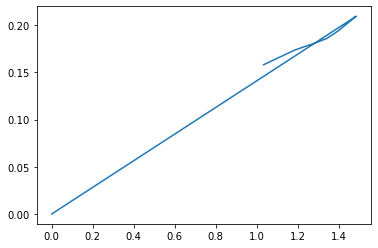

In [8]:
DDHT.eval()
test_encoder_output_vector, test_first_hitting_time = DDHT(test_batch, test_time_to_event)

plt.plot(np.array(test_encoder_output_vector.detach().cpu()[0][:,1]), test_encoder_output_vector.detach().cpu()[0][:,2])
print(test_encoder_output_vector[0,:10])
print("event=%d, time_to_event=%d, latent_variable=%f" % (test_event.item(), test_time_to_event.item(), test_latent_variable.item()))

(0.0, 1.0)

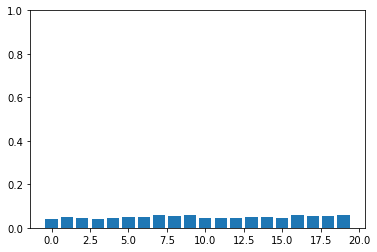

In [9]:
plt.bar([i for i in range(test_first_hitting_time.size(1))], test_first_hitting_time.squeeze().cpu().detach().numpy())
plt.ylim([0,1])

### Scoring our model

In [10]:
from poc_data import PocDataset

VAL_NUM_CASES = 2**6

val_poc_raw_dataset = PocDataset(num_cases=VAL_NUM_CASES)
val_data_loader = torch.utils.data.DataLoader(val_poc_raw_dataset,batch_size=2**6)
val_input_batch, val_event_batch, val_time_to_event_batch, _ = next(iter(val_data_loader))
val_input_batch = val_input_batch.to(DEVICE)
val_event_batch = val_event_batch.to(DEVICE)
val_time_to_event_batch = val_time_to_event_batch.to(DEVICE)


In [11]:
DDHT.eval()

val_output_batch, val_first_hitting_time_batch = DDHT(val_input_batch, val_time_to_event_batch)
val_loss1 = loss_1_batch(val_first_hitting_time_batch, val_event_batch, val_time_to_event_batch, MAX_LENGTH)/VAL_NUM_CASES
val_loss2 = loss_2_batch(val_first_hitting_time_batch, val_event_batch, val_time_to_event_batch, NUM_CAUSES, MAX_LENGTH, SIGMA, DEVICE)/VAL_NUM_CASES
val_loss3 = loss_3_batch(val_output_batch, val_input_batch.detach())/VAL_NUM_CASES


print("val_loss1=", val_loss1.item())
print("val_loss2=", val_loss2.item())
print("val_loss3=", val_loss3.item())


val_loss1= 2.9910523891448975
val_loss2= 26.711164474487305
val_loss3= 9231.7861328125


Records:
val_loss1= 3.585130214691162
val_loss2= 15.078988075256348
val_loss3= 7631.45654296875

In [13]:
PATH = "C:/Users/marij/Desktop/THESIS ECO/DDHT/DDHT_pytorch/models/model_2.pth"
torch.save(DDHT.state_dict(), PATH)